submit format:

header = id, class

In [ ]:
!nvidia-smi

Sun Apr 17 19:49:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |  13202MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models
!pip install -q -U albumentations

  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-qlg_vf_r
  Running command git clone -q https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-qlg_vf_r
  Created wheel for timm: filename=timm-0.6.1-py3-none-any.whl size=480302 sha256=744660562f4b3dcf7d847cb253fce77459a13e015df08446892ef55863fa3d12
  Stored in directory: /tmp/pip-ephem-wheel-cache-ahwrx47o/wheels/69/3d/b0/be55cbadabd87a0e1875d63c7492d199097a39cc2433637650
Successfully built timm
     |████████████████████████████████| 102 kB 10.6 MB/s 
     |████████████████████████████████| 47.8 MB 1.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models

from sklearn.metrics import f1_score

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Config

In [ ]:
class Config:
  IMG_SIZE_H = 384
  IMG_SIZE_W = 384
  BATCH_SIZE = 16
  EPOCHS = 11
  FT_EPOCHS = 31
  DEVICE = torch.device('cuda')
  MODEL_LOAD_PATH = '/content/best_model.pt'
  train_images = '/content/drive/MyDrive/WoodHack_train'
  test_images = '/content/drive/MyDrive/WoodHack_test'

Choice models

https://rwightman.github.io/pytorch-image-models/

https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055

In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
# pprint(model_names)

In [ ]:
# https://stackoverflow.com/questions/71535805/how-to-fine-tune-a-pre-trained-swin-transformer-for-a-downstream-task-segmenta
model = timm.create_model('swin_large_patch4_window12_384_in22k', in_chans = 3, pretrained = True, num_classes=0, global_pool='avg') # global_pool='catavgmax' # features_only=True
print(model.default_cfg)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'url': 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22k.pth', 'num_classes': 21841, 'input_size': (3, 384, 384), 'pool_size': None, 'crop_pct': 1.0, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'architecture': 'swin_large_patch4_window12_384_in22k'}


In [ ]:
# model.get_classifier()
# model.global_pool

dummy_image = torch.randn(1,3,384,384)
model.forward_features(dummy_image).shape
model.forward(dummy_image).shape

In [ ]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/WoodHack_train/1/IMG_0581.png')
image = image.resize((384, 384), Image.ANTIALIAS)
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2,0)[None]
image.shape

torch.Size([1, 3, 384, 384])

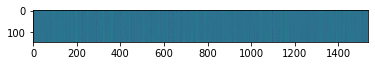

In [ ]:
feat_output = model.forward_features(image)
# plt.imshow(feat_output[0].transpose(0,2).sum(-1).detach().numpy())
plt.imshow(np.squeeze(feat_output.detach().numpy()))

Model

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(4096, 3)
    
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fc(x)
        return x

    def set_parameter_requires_grad(self, freeze: bool):
        for param in self.vgg16.features.parameters():
            param.requires_grad = not freeze
        if not freeze:
          for name ,child in (self.vgg16.named_children()):
            if name.find('BatchNorm') != -1:
                for param in child.parameters():
                    param.requires_grad = False

In [ ]:
# SWIN
from torch.nn import Flatten

class SWIN(nn.Module):
    def __init__(self):
        super().__init__()
        self.swin = timm.create_model('swin_large_patch4_window12_384_in22k', in_chans = 3, pretrained = True, num_classes=0)
        for param in self.swin.parameters():
            param.requires_grad = False

        self.flatten = Flatten()
        self.fc = nn.Linear(1536, 3)
    
    def forward(self, x):
        x = self.swin(x)
        # x = self.flatten(x)
        x = self.fc(x)
        return x

    def set_parameter_requires_grad(self, freeze: bool):
        for param in self.swin.parameters():
            param.requires_grad = not freeze
        if not freeze:
          for name ,child in (self.swin.named_children()):
            if name.find('BatchNorm') != -1:
                for param in child.parameters():
                    param.requires_grad = False

Data

In [ ]:
transform_train = transforms.Compose([
        #  transforms.CenterCrop(2048),
        #  transforms.RandomResizedCrop(2048),
         transforms.Resize((Config.IMG_SIZE_H, Config.IMG_SIZE_W)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
        #  transforms.CenterCrop(2048),
         transforms.Resize((Config.IMG_SIZE_H, Config.IMG_SIZE_W)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = datasets.ImageFolder(Config.train_images, transform=transform_train)

In [ ]:
print(train_data.class_to_idx)

{'1': 0, '3': 1, 'drova': 2}


In [ ]:
# take random 20 percent of indexes from dataset
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
val_size = 0.2
val_inds = subset_ind(train_data, val_size)

train_dataset = Subset(train_data, [i for i in range(len(train_data)) if i not in val_inds])
val_dataset = Subset(train_data, val_inds)

print(f'training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

training size: 463
validation size: 115


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 384, 384]), 0)

Train

In [ ]:
device = Config.DEVICE

In [ ]:
def train(net, loss_fn, optimizer, train_loader,val_loader, n_epoch=10):
    best_metrics = 0

    for epoch in range(n_epoch):
        print(f'Epoch {epoch + 1}')
        epoch_loss = 0.0
        epoch_val_loss = 0.0
        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            net.train()
            X_batch, y_batch = batch

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += y_pred.shape[0] * loss.item()

            # print statistics
            # running_loss += loss.item()
            # if i % 2000 == 1999:    # print every 2000 mini-batches
            #     print('[%d, %5d] loss: %.3f' %
            #           (epoch + 1, i + 1, running_loss / 2000))
            #     running_loss = 0.0
            # print epoch loss
        print('train loss: ', epoch_loss / len(train_dataiter))

        if (epoch % 5) == 0:
          with torch.no_grad():
              net.eval()
              metrics = []
              for batch in val_loader:
                  x, y = batch
                  x = x.to(device)
                  y = y.to(device)
                  y_pred = net(x)
                  loss = loss_fn(y_pred, y)

                  y_true = y.detach().cpu().numpy() 
                  y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
                  f1_batch = f1_score(y_true, y_pred, average='macro')
                  metrics.append(f1_batch)
                  epoch_val_loss += y_pred.shape[0] * loss.item()
              print('val loss: ', epoch_val_loss / len(train_dataiter))
              
              metrics = np.mean(np.array(metrics))
              print(f'f1 macro: {metrics}')
              # если стало лучше - сохраняем на диск и обновляем лучшую метрику
              if metrics > best_metrics:
                  print('New best model with test f1 macro:', metrics)
                  torch.save(net.state_dict(), f'./best_model_{epoch}_{str(np.round(metrics, 2))}.pt')
                  best_metrics = metrics

    return net

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

983

In [ ]:
# net = New_VGG16().to(device)
net = SWIN().to(device)

# lr = 5e-4
lr = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net = train(net, loss_fn, optimizer, train_loader, val_loader, n_epoch=Config.EPOCHS)

Epoch 1


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  8.23120445115813
val loss:  0.6648510026520696
f1 macro: 0.9436944634313055
New best model with test f1 macro: 0.9436944634313055
Epoch 2


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  2.5975218957354285
Epoch 3


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.820524506013969
Epoch 4


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.387551408903352
Epoch 5


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.264437159073764
Epoch 6


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.0322048972392905
val loss:  0.2750267866870453
f1 macro: 0.9913419913419913
New best model with test f1 macro: 0.9913419913419913
Epoch 7


  0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
# params_to_update = []
#   for name,param in net.named_parameters():
#       if param.requires_grad == True:
#           params_to_update.append(param)
#           print("\t",name)

In [ ]:
opt_params = optimizer.state_dict()
net.set_parameter_requires_grad(freeze=False)

lr = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer.load_state_dict(opt_params)
optimizer.param_groups[0]['lr'] = 5e-4

net = train(net, loss_fn, optimizer, train_loader, val_loader, n_epoch=Config.FT_EPOCHS)

Epoch 1


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  7.112677393291459
val loss:  1.0597500310375774
New best model with test f1 macro: 0.9342248437836673
Epoch 2


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  4.669537786105327
Epoch 3


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  3.2283598661808104
Epoch 4


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.7437747977674007
Epoch 5


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  3.2407813642719954
Epoch 6


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  3.678796327977987
val loss:  1.5041563308743584
Epoch 7


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.6670123136181842
Epoch 8


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  0.9670964965295972
Epoch 9


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  14.17065346343764
Epoch 10


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  8.079397183553926
Epoch 11


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  4.3708365563431695
val loss:  0.6690043510933374
Epoch 12


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  5.952689326015012
Epoch 13


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  4.877131997511305
Epoch 14


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  4.928796500738325
Epoch 15


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  2.491205750675551
Epoch 16


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.7504907208815987
val loss:  1.4431202037677426
Epoch 17


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  4.421677351098283
Epoch 18


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  2.1075241284059554
Epoch 19


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.6133633705562558
Epoch 20


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  2.247987001347516
Epoch 21


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  1.6939555650641178
val loss:  0.9621968149480506
Epoch 22


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  2.802735297004331
Epoch 23


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  5.290144899667337
Epoch 24


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  3.3819174265553213
Epoch 25


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  3.919524398600233
Epoch 26


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  14.636346531839207
val loss:  5.109443261705596
Epoch 27


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  21.188515582989
Epoch 28


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  19.239830105469146
Epoch 29


  0%|          | 0/29 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbb513bf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbb513bf80>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pyt

train loss:  15.809615069422229
Epoch 30


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  15.599403130597082
Epoch 31


  0%|          | 0/29 [00:00<?, ?it/s]

train loss:  15.643543629810727
val loss:  3.8109203227635087


In [ ]:
net.load_state_dict(torch.load('/content/best_model_5_0.99.pt'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import classification_report

real = []
pred = []

with torch.no_grad():
    metrics = []
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)

        y_true = y.detach().cpu().numpy().tolist() 
        y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1).tolist()
        real.extend(y_true)
        pred.extend(y_pred)

print(classification_report(real, pred))

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       0.97      1.00      0.99        38
           2       1.00      1.00      1.00         8

    accuracy                           0.99       115
   macro avg       0.99      1.00      0.99       115
weighted avg       0.99      0.99      0.99       115



Predict

In [ ]:
# net.load_state_dict(torch.load(Config.MODEL_LOAD_PATH))

In [ ]:
from PIL import Image
import glob
class PredictDataset(object):
    def __init__(self, list_of_files, transforms):
        self.dataset = list_of_files
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.dataset[idx]
        item = Image.open(item)
        item = self.transforms(item)
        return item

    def __len__(self):
        return len(self.dataset)

In [ ]:
test_files = glob.glob(Config.test_images+'/*.*')
test_files.sort(key= lambda x: int(x.split('/')[-1].strip('.png').strip('.JPG')))

predict_ds = PredictDataset(test_files, transforms=transform_test)
predict_loader = DataLoader(predict_ds, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True)

In [ ]:
pred = []

with torch.no_grad():
    net.eval()
    metrics = []
    for batch in tqdm(predict_loader):
        batch = batch.to(device)
        y_pred = net(batch)
 
        y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1).tolist()
        pred.extend(y_pred)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
submit = pd.DataFrame({'id':np.arange(1,250), 'class': pred})

«1» - первый и второй сорта

«3» - третий сорт

«0» - класс дрова


{'1': 0, '3': 1, 'drova': 2}

In [ ]:
idx_to_class_map = {0:1, 1:3, 2:0}

In [ ]:
submit['class'] = submit['class'].apply(lambda x: idx_to_class_map[x])

In [ ]:
submit.to_csv('submit_6_epoch_swin.csv', index=False)
submit

,id,class
0,1,0
1,2,3
2,3,0
3,4,3
4,5,1
...,...,...
244,245,1
245,246,1
246,247,1
247,248,1
